# Credit Card Fraud Detection

Coded by Emile Badran in April/2018

This notebook aims to identify fraudulent credit card transactions.

Correctly finding fraud was prioritized rather than correctly labeling non-fraudulent transactions.

**Acknowledgments**

The dataset used in this notebook was collected and analysed for a research on big data mining and fraud detection by the Machine Learning Group of the Université Libre de Bruxelles (http://mlg.ulb.ac.be). The data can be downloaded from https://www.kaggle.com/mlg-ulb/creditcardfraud/data

Authors of the original paper are: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. *Calibrating Probability with Undersampling for Unbalanced Classification.* In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import RandomOverSampler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn import ensemble

### Importing and inspecting the data set

In [2]:
# This notebook runs on Google Cloud

import google.datalab.storage as storage
from io import BytesIO

mybucket = storage.Bucket('la-data')
data_file = mybucket.object('creditcard.csv')

uri = data_file.uri
%gcs read --object $uri --variable data

raw_data = pd.read_csv(BytesIO(data))
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Column metadata:
- Time: Number of seconds elapsed between each transaction (over two days)
- V1 to V28: PCA components
- Amount: USD amount for each transaction
- Class: Whether the transaction was a fraud (1) or not-fraud (0)

The dataset contains credit card transactions made in September 2013 by European cardholders. It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, features V1 to V28 are the principal components obtained from PCA.

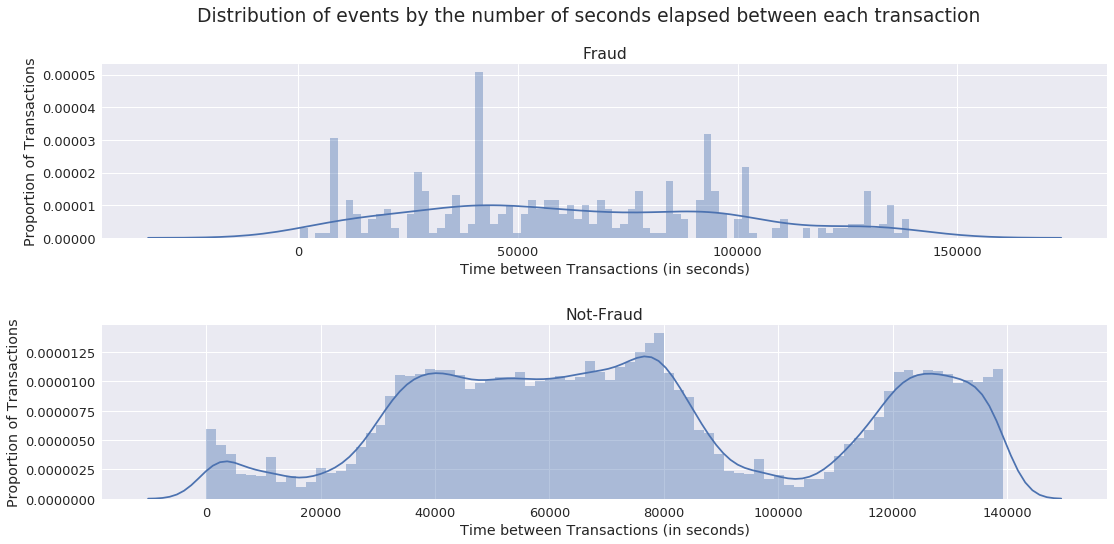

In [3]:
# Set the figure size, grid and font:
plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(2, 1)
gs.update(hspace=.5)
sns.set(font_scale=1.3)

# Plot the first graph filtering outlier data:
ax1 = plt.subplot(gs[0])
ax1.set_title('Fraud')
sns.distplot(raw_data.Time[(raw_data.Class == 1)&(
    raw_data.Time < raw_data.Time.quantile(.75))], bins=80)
plt.xlabel('Time between Transactions (in seconds)')
plt.ylabel('Proportion of Transactions')

# Plot the second graph filtering outlier data:
ax2 = plt.subplot(gs[1])
ax2.set_title('Not-Fraud')
sns.distplot(raw_data.Time[(raw_data.Class == 0)&(
    raw_data.Time < raw_data.Time.quantile(.75))], bins=80)
plt.xlabel('Time between Transactions (in seconds)')
plt.ylabel('Proportion of Transactions')

# Set plot title:
plt.suptitle('Distribution of events by the number of seconds elapsed between each transaction')
plt.show()

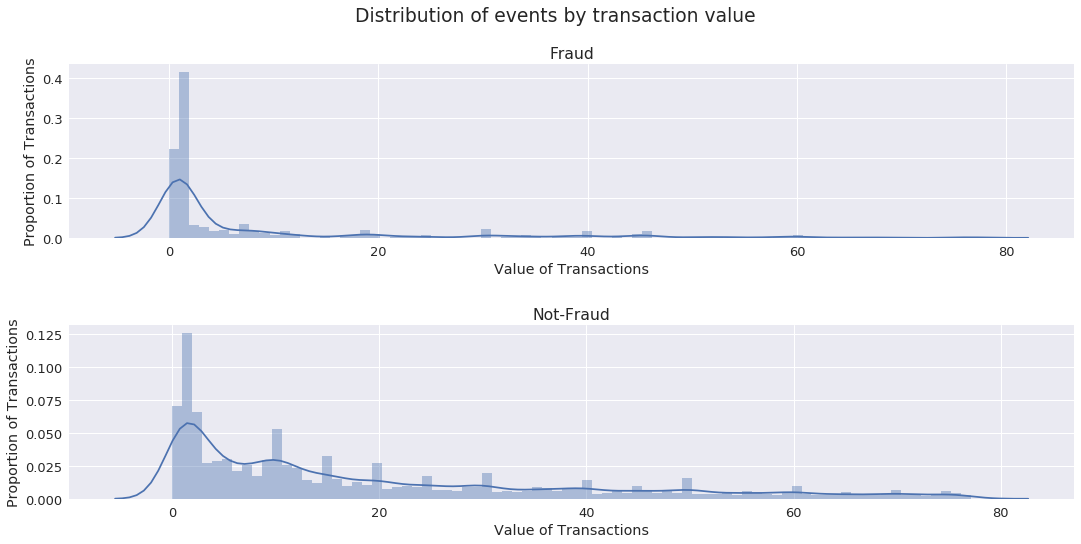

In [4]:
# Set the figure size, grid and font:
plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(2, 1)
gs.update(hspace=.5)
sns.set(font_scale=1.3)

# Plot the first graph filtering outlier data:
ax1 = plt.subplot(gs[0])
ax1.set_title('Fraud')
sns.distplot(raw_data.Amount[(raw_data.Class == 1)&(
    raw_data.Amount < raw_data.Amount.quantile(.75))], bins=80)
plt.xlabel('Value of Transactions')
plt.ylabel('Proportion of Transactions')

# Plot the second graph filtering outlier data:
ax2 = plt.subplot(gs[1])
ax2.set_title('Not-Fraud')
sns.distplot(raw_data.Amount[(raw_data.Class == 0)&(
    raw_data.Amount < raw_data.Amount.quantile(.75))], bins=80)
plt.xlabel('Value of Transactions')
plt.ylabel('Proportion of Transactions')

# Set plot title:
plt.suptitle('Distribution of events by transaction value')
plt.show()

There's nothing unusual about the distributions of Fraud transactions. The timing of fraud transactions is more evenly distributed than not-fraud transactions. Fraud transactions values are mostly between 0 and 2.

### Resampling the data set to compensate class imbalance
There are 492 frauds out of 284,807 transactions. Class imbalance is 0.172%. Fraud transactions will be oversampled so the algorithm can be properly trained.

In [3]:
sample_train = shuffle(raw_data, n_samples=189543) # train sample with 2/3 of the data set
sample_test = shuffle(raw_data, n_samples=95264) # test sample with 1/3 of the data set

In [4]:
# Random over sample fraud transactions for training purposes:
ros = RandomOverSampler(ratio='minority')
x_train_balanced, y_train_balanced = ros.fit_sample(sample_train.iloc[:,:-1], sample_train.Class)

In [5]:
# The resulting balanced training sample has an equal amount of fraud/no-fraud transactions:
df = pd.DataFrame(data=x_train_balanced)
df['y'] = y_train_balanced
df.y.value_counts()

1    189204
0    189204
Name: y, dtype: int64

### Selecting the most valuable features
Features with lower predictive potential are filtered to reduce processing time when running models and improve model stability. The score function used to select the most valuable features is ANOVA f-values.

In [6]:
# Select the 10 best features:
kbest = SelectKBest(f_classif, k=10).fit(x_train_balanced, y_train_balanced)

# Filter train and test matrices with only the k best features:
kbest_train_balanced = kbest.transform(x_train_balanced)
kbest_sample_test = kbest.transform(sample_test.iloc[:,:-1])

In [7]:
# Inspect sample sizes and number of dimensions
print(x_train_balanced.shape)
print(y_train_balanced.shape)
print(kbest_train_balanced.shape)
print(kbest_sample_test.shape)

(378408, 30)
(378408,)
(378408, 10)
(95264, 10)


The feature space was reduced from 30 to 10 variables.

# Predicting credit card fraud
Since this is a classification problem, the following models are used to detect credit card fraud. Their resulting accurracy are compared in the conclusion section at the end of this notebook.

### KNN Classifier

KNN was iteratively run (by hand) with the following parameter options:
- weights: ['uniform', 'entropy']
- number of neighbors: [10, 50, 100, 500, 1000]

The best results were obtained with uniform weighting and 1000 n_neighbors.

In [ ]:
# Define the KNN classifier and parameters.
neighbors = KNeighborsClassifier(n_neighbors=1000, weights='uniform', n_jobs=-1)
neighbors.fit(kbest_train_balanced,y_train_balanced)
neighbors_predicted = neighbors.predict(kbest_sample_test)

In [ ]:
# Generate a confusion matrix to inspect the results
confusion_matrix(neighbors_predicted, sample_test.Class)

#### Cross-validation with confusion matrices and specificity score

In [18]:
# Cross-validate the model 
print('Cross-Validation:')

step = int(len(sample_test)/5)
start = 0
for i in range(5):
  stop = start+step
  
  neighbors_predicted = neighbors.predict(kbest_sample_test[start:stop])
  
  print('\nSample range: ', start, 'to', stop)
  print(confusion_matrix(neighbors_predicted, sample_test.Class[start:stop]))
  print('Sensitivity: ', recall_score(sample_test.Class[start:stop], neighbors_predicted))
  start += step

Cross-Validation:

Sample range:  0 to 19052
[[17870     1]
 [ 1151    30]]
Sensitivity:  0.967741935483871

Sample range:  19052 to 38104
[[17827     0]
 [ 1197    28]]
Sensitivity:  1.0

Sample range:  38104 to 57156
[[17863     0]
 [ 1150    39]]
Sensitivity:  1.0

Sample range:  57156 to 76208
[[17835     0]
 [ 1182    35]]
Sensitivity:  1.0

Sample range:  76208 to 95260
[[17786     0]
 [ 1236    30]]
Sensitivity:  1.0


Not bad for starters. The model doesn't take too long to run either.

### Random Forest Classifier
The random forest classifier model has many parameters to tune. Instead of tuning them by hand, RandomizedSearchCV was used to randomly select and test 20 parameter combinations and select the most promising. The method also cross-validates each combination twice, totalling 40 fits.

In [19]:
# Create the RandomizedSearchCV parameter grid:
params = {'n_estimators': [200, 233, 266, 300, 333, 366, 400, 433, 466, 500],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

# Declare the model:
rfc = ensemble.RandomForestClassifier()

# Declare randomized search CV
rfc_random_CV = RandomizedSearchCV(estimator=rfc, param_distributions=params,
                                n_iter=20, cv=2, verbose=1, n_jobs=-1)

# Fit the random search model
rfc_random_CV.fit(kbest_train_balanced,y_train_balanced)

#Inspect the best parameters from RandomizedSearchCV
rfc_random_CV.best_params_

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 23.3min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 433}

** Fit the RandomForestClassifier with the selected parameters and cross-validate to check for overfitting.**

In [32]:
# Declare and fit the model with the selected parameters
rfc = ensemble.RandomForestClassifier(bootstrap=True, max_depth=110, max_features='sqrt',
                            min_samples_leaf=1, min_samples_split=2, n_estimators=433,
                            n_jobs=-1)

rfc.fit(kbest_train_balanced,y_train_balanced)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=433, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
# Cross-validate the model 
print('Cross-Validation:')

step = int(len(sample_test)/5)
start = 0
for i in range(5):
  stop = start+step
  
  rfc_predicted = rfc.predict(kbest_sample_test[start:stop])
  
  print('\nSample range: ', start, 'to', stop)
  print(confusion_matrix(rfc_predicted, sample_test.Class[start:stop]))
  print('Sensitivity: ', recall_score(sample_test.Class[start:stop], rfc_predicted))
  start += step

Cross-Validation:

Sample range:  0 to 19052
[[19019     5]
 [    2    26]]
Sensitivity:  0.8387096774193549

Sample range:  19052 to 38104
[[19023     1]
 [    1    27]]
Sensitivity:  0.9642857142857143

Sample range:  38104 to 57156
[[19013     1]
 [    0    38]]
Sensitivity:  0.9743589743589743

Sample range:  57156 to 76208
[[19016     2]
 [    1    33]]
Sensitivity:  0.9428571428571428

Sample range:  76208 to 95260
[[19022     0]
 [    0    30]]
Sensitivity:  1.0


Random Forest has a slightly lower sensitivity than KNN, but still a solid score.

### Logistic Regression
There are fewer parameters to adjust in the logistic regression, so GridSearchCV will be used instead of RandomizedSearchCV. GridSearchCV exaustively tests all parameter combinations, in this case totalling 16 fits.

In [22]:
# Declare the parameters
params = {'penalty': ['l1', 'l2'],
               'C': [1, 10, 20, 30],
              'warm_start': [True, False]}

# Declare the model
lr = LogisticRegression()

# Declare the GridSearchCV function
lr_gsearch = GridSearchCV(lr, params, n_jobs=-1)

# Fit the model
lr_gsearch.fit(kbest_train_balanced,y_train_balanced)

# Save results in a DataFrame
lr_results = pd.DataFrame(data=lr_gsearch.cv_results_)

# View the estimator with the best parameter combination
lr_gsearch.best_estimator_

LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=True)

In [23]:
# Declare the model with the selected parameters
lr = LogisticRegression(C=10, penalty='l1', warm_start=False, n_jobs=-1)

# Fit the model
lr.fit(kbest_train_balanced,y_train_balanced)

# Display coefficients and intercept
print('Coefficients')
print(lr.coef_)
print(lr.intercept_)

Coefficients
[[-0.02785043 -0.18301924  0.65985177 -0.16220903 -0.43742813  0.1164675
  -0.64076109 -0.69968764 -0.24723438  0.13356597]]
[-2.7605285]


In [73]:
# Cross-validate the model 
print('Cross-Validation:')

step = int(len(sample_test)/5)
start = 0
for i in range(5):
  stop = start+step
  
  lr_predicted = lr.predict(kbest_sample_test[start:stop])
  
  print('\nSample range: ', start, 'to', stop)
  print(confusion_matrix(lr_predicted, sample_test.Class[start:stop]))
  print('Sensitivity: ', recall_score(sample_test.Class[start:stop], lr_predicted))
  start += step

Cross-Validation:

Sample range:  0 to 19052
[[18573     2]
 [  454    23]]
Sensitivity:  0.92

Sample range:  19052 to 38104
[[18557     0]
 [  468    27]]
Sensitivity:  1.0

Sample range:  38104 to 57156
[[18563     1]
 [  462    26]]
Sensitivity:  0.9629629629629629

Sample range:  57156 to 76208
[[18538     5]
 [  468    41]]
Sensitivity:  0.8913043478260869

Sample range:  76208 to 95260
[[18550     1]
 [  469    32]]
Sensitivity:  0.9696969696969697


The coefficients seem to be under control, so no need to run lasso or ridge regression.
Sensitivity scores are high, but specificity is lower than KNN and Random Forest.
A solid result, although not perfect. An indication that Gradient Boosting can be even more promising.

### Support Vector Machine
Of all models, SVM is the most computationally expensive.

The "n_jobs=-1" parameter instructs RandomizedSearchCV to use all CPU cores. Memory use was relatively low (~2.6 GB) but the processes took more than 14 hours to complete on a Google Cloud Instance with 8-cores and 52GB memory and were aborted.

To save time and computing power, SVC was fitted with a smaller sample and a single parameter combination:

In [24]:
# Declare and fit the model and parameters
svc = svm.SVC(C=10, kernel='linear', decision_function_shape='ovr',
              gamma='auto')

svc.fit(kbest_train_balanced[:38104], y_train_balanced[:38104])

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
# Predict with SVC
svc_predicted = svc.predict(kbest_sample_test[:38104])

In [26]:
# To save time and computing power, the confusion matrix will be generated only once
confusion_matrix(svc_predicted, sample_test.Class[:38104])

array([[38038,    15],
       [    7,    44]])

The score is not very impressive, possibly because the sample size is smaller. Considering the high scores obtained from the other less computationally intensive models, there is no good reason to use SVC in this specific data set.

### Gradient Boosting
To start, Gradient Boosting was run with the default settings obtaining 97% sensitivity.

In [34]:
gbc = ensemble.GradientBoostingClassifier()

# Fit the gradient boosting
gbc.fit(kbest_train_balanced,y_train_balanced)

#Inspect the best parameters from RandomizedSearchCV
gbc_predicted = gbc.predict(kbest_sample_test)
print(confusion_matrix(gbc_predicted, sample_test.Class))
print('\nsensitivity = ', recall_score(sample_test.Class, gbc_predicted))

[[94383     5]
 [  718   158]]

sensitivity =  0.9693251533742331


#### Run RandomizedSearchCV to see if the result can be improved
To save time and computing power, RandomizedSearchCV will run on a smaller sample.

In [27]:
params = {'loss': ['deviance', 'exponential'],
          'n_estimators': [2,5,10],
          'max_depth': [5,10,20],
          'min_samples_split': [2,10],
          'min_samples_leaf': [1,10,20],
          'criterion': ['friedman_mse','mae']
         }

gbc = ensemble.GradientBoostingClassifier()
gbc_random_CV = RandomizedSearchCV(estimator=gbc, param_distributions=params,
                                n_iter=10, cv=2, verbose=1, n_jobs=-1)

# Fit the random grid
gbc_random_CV.fit(kbest_train_balanced[:38104],y_train_balanced[:38104])

#Inspect the best parameters from RandomizedSearchCV
gbc_random_CV.best_params_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 23.0min finished


{'criterion': 'mae',
 'loss': 'deviance',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

#### Attempt 1. Running GBC with RandomizedSearchCV parameters
Fitting and predicting with GBC and the parameters selected by RandomizedSearchCV required +5 hours of processing time. The process was aborted.

On a second attempt, Gradient Boosting was run with a lower depth and less estimators.

#### Attempt 2. Runnning GBC with sample=5000, max_depth=10, n_estimators=10
Not a great result, but running time was less than 30 minutes.

In [10]:
gbc = ensemble.GradientBoostingClassifier(criterion='mae', loss='deviance',
                                         max_depth=10, min_samples_leaf=1,
                                         min_samples_split=2, n_estimators=10)

gbc_fit = gbc.fit(kbest_train_balanced,y_train_balanced)

# Cross-validate the model 
print('Cross-Validation:')
start = 0
step = 5000
stop = 5000
for i in range(5):  
  gbc_predicted = gbc_fit.predict(kbest_sample_test[start:stop])
  print('\nSample range: ', start, 'to', stop)
  print(confusion_matrix(gbc_predicted, sample_test.Class[start:stop]))
  print('Sensitivity: ', recall_score(sample_test.Class[start:stop], gbc_predicted))
  start += step
  stop += step

Cross-Validation:

Sample range:  0 to 5000
[[4991    1]
 [   1    7]]
Sensitivity:  0.875

Sample range:  5000 to 10000
[[4989    4]
 [   0    7]]
Sensitivity:  0.6363636363636364

Sample range:  10000 to 15000
[[4986    5]
 [   0    9]]
Sensitivity:  0.6428571428571429

Sample range:  15000 to 20000
[[4990    2]
 [   0    8]]
Sensitivity:  0.8

Sample range:  20000 to 25000
[[4991    2]
 [   3    4]]
Sensitivity:  0.6666666666666666


#### Attempt 3. Running GBC with sample=5000 max_depth=2, n_estimators=100
Still not a great result. Running time was just under 30mins.

In [8]:
gbc = ensemble.GradientBoostingClassifier(criterion='mae', loss='deviance',
                                         max_depth=2, min_samples_leaf=1,
                                         min_samples_split=2, n_estimators=100)

gbc_fit = gbc.fit(kbest_train_balanced,y_train_balanced)

# Cross-validate the model 
print('Cross-Validation:')
start = 0
step = 5000
stop = 5000
for i in range(5):  
  
  gbc_predicted = gbc_fit.predict(kbest_sample_test[start:stop])
  
  print('\nSample range: ', start, 'to', stop)
  print(confusion_matrix(gbc_predicted, sample_test.Class[start:stop]))
  print('Sensitivity: ', recall_score(sample_test.Class[start:stop], gbc_predicted))
  start += step
  stop += step

Cross-Validation:

Sample range:  0 to 5000
[[4985    5]
 [   2    8]]
Sensitivity:  0.6153846153846154

Sample range:  5000 to 10000
[[4993    1]
 [   2    4]]
Sensitivity:  0.8

Sample range:  10000 to 15000
[[4989    2]
 [   1    8]]
Sensitivity:  0.8

Sample range:  15000 to 20000
[[4986    3]
 [   2    9]]
Sensitivity:  0.75

Sample range:  20000 to 25000
[[4991    3]
 [   1    5]]
Sensitivity:  0.625


#### Other experiment 1. Running logit with sample=5000
Clearly, larger sample sizes improve the quality of predictions of decision tree classifiers. But does sample size affect to the same extent the quality of predictions from regression classifiers? Let's have a look:

In [14]:
import time
start_time = time.time()

# Declare the model with the selected parameters
lr = LogisticRegression(C=10, penalty='l1', warm_start=False, n_jobs=-1)

# Fit the model
lr.fit(kbest_train_balanced,y_train_balanced)

# Display coefficients and intercept
print('Coefficients')
print(lr.coef_)
print(lr.intercept_)

# Cross-validate the model 
print('\nCross-Validation:')
start = 0
step = 5000
stop = 5000

for i in range(5):  
  
  lr_predicted = lr.predict(kbest_sample_test[start:stop])
  
  print('\nSample range: ', start, 'to', stop)
  print(confusion_matrix(lr_predicted, sample_test.Class[start:stop]))
  print('Sensitivity: ', recall_score(sample_test.Class[start:stop], lr_predicted))
  start += step
  stop += step

print("--- %s seconds ---" % (time.time() - start_time))  

Coefficients
[[-0.21345638  0.77262315 -0.10588206 -0.16207304 -0.35014153  0.46746007
  -0.74038667 -0.72534584 -0.39655498  0.09457281]]
[-2.97422997]

Cross-Validation:

Sample range:  0 to 5000
[[4870    0]
 [ 118   12]]
Sensitivity:  1.0

Sample range:  5000 to 10000
[[4855    2]
 [ 136    7]]
Sensitivity:  0.7777777777777778

Sample range:  10000 to 15000
[[4870    0]
 [ 118   12]]
Sensitivity:  1.0

Sample range:  15000 to 20000
[[4875    0]
 [ 116    9]]
Sensitivity:  1.0

Sample range:  20000 to 25000
[[4866    0]
 [ 126    8]]
Sensitivity:  1.0
--- 1.3912937641143799 seconds ---


Looks like the accuracy of logistic regressions are also affected by sample sizes, likely because smaller samples may have higher variation between themselves and the population.

#### Other experiment 2. Random Forest with sample=5000
To double-check if decision-based trees are heavily affected by sample size, the Random Forest Classifier was run with a smaller sample size.

In [13]:
start_time = time.time()

# Declare and fit the model with the selected parameters
rfc = ensemble.RandomForestClassifier(bootstrap=True, max_depth=110, max_features='sqrt',
                            min_samples_leaf=1, min_samples_split=2, n_estimators=433,
                            n_jobs=-1)

# Fit the model
rfc.fit(kbest_train_balanced,y_train_balanced)


# Cross-validate the model 
print('Cross-Validation:')
start = 0
step = 5000
stop = 5000

for i in range(5):  
  
  rfc_predicted = rfc.predict(kbest_sample_test[start:stop])
  
  print('\nSample range: ', start, 'to', stop)
  print(confusion_matrix(rfc_predicted, sample_test.Class[start:stop]))
  print('Sensitivity: ', recall_score(sample_test.Class[start:stop], rfc_predicted))
  start += step
  stop += step

print("--- %s seconds ---" % (time.time() - start_time))  

Cross-Validation:

Sample range:  0 to 5000
[[4988    1]
 [   0   11]]
Sensitivity:  0.9166666666666666

Sample range:  5000 to 10000
[[4991    1]
 [   0    8]]
Sensitivity:  0.8888888888888888

Sample range:  10000 to 15000
[[4988    0]
 [   0   12]]
Sensitivity:  1.0

Sample range:  15000 to 20000
[[4991    0]
 [   0    9]]
Sensitivity:  1.0

Sample range:  20000 to 25000
[[4992    1]
 [   0    7]]
Sensitivity:  0.875
--- 102.20362830162048 seconds ---


## Conclusion
All models performed well with this data set, so the trade-off between processing time (and costs) and model precision is an important consideration.

Overall, Random Forests seem to offer the best cost/accuracy ratio, working well with small and larger sample sizes.

If sensitivity is to be prioritized, KNN had one of the highest sensitivity scores and very fast running time.

If specificity were also to be taken into consideration then logistic regression was one of the fastest models with relatively good accuracy on both large and small samples.

SVC was by far the most computationally expensive model to the point of being impractical for this specific data set.

Gradient Boosting does not (yet) support parallel computing so although not computationally expensive, it does require more time than Random Forest and Logistic Regression to process.